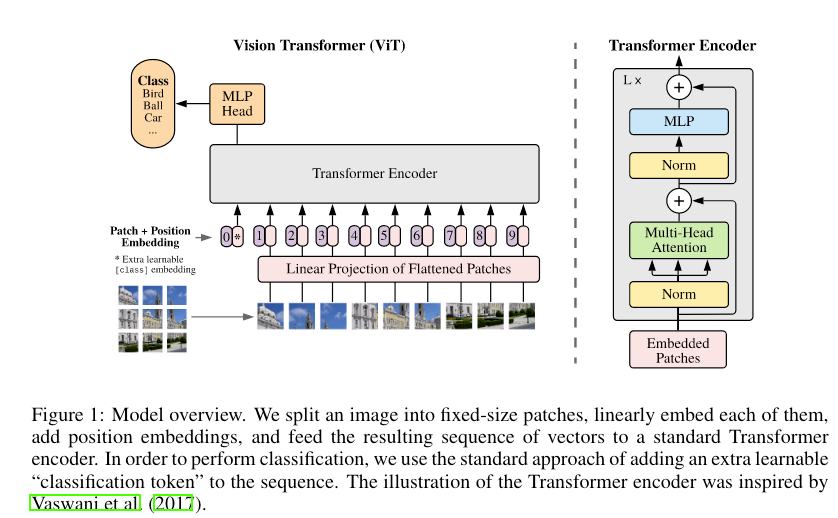

In [1]:

from IPython.display import display,Image
display(Image(data="image/vision.png"))

In [2]:


import torch 
import numpy as np 
from PIL import Image
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt 


<br>
<br>

# `#01 Image to Patch:`

<br>
<br>

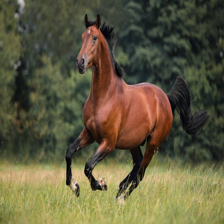

In [4]:
img = Image.open("image/images.jpg")
img = img.resize((224,224))
img 

In [5]:

# convert the image into numpy array:
img_array = np.array(img)
print("image shape: ", img_array.shape)

image shape:  (224, 224, 3)


In [6]:

# ---------------------------- Case:01 ---------------------------
x = Image.open("image/images.jpg")
x = x.resize((224,224))
x = np.array(x)
P = 16
c = 3
patches = img_array.reshape(-1,16*16*3)

""" 
আমরা উপরের কোডটি ব্যবহার করে image কে patch এ ভাগ করতে পারবো না, কারণ, ইমেজ ডেটা সাধারণত row-major 
অর্ডারে স্টোর করা হয়, অর্থাৎ প্রথমে উচ্চতা (rows), তারপর প্রস্থ (columns), তারপর কালার চ্যানেল. 

**case:01:**
আচ্ছা, আমার image হচ্ছে, 224x224x3 এখন এইটাকে, (-1,16*16*3) বা (-1,768) এ ভাগ হবে 
কীভাবে, (224,224*3) = (224,672) , কিন্তু, আমাদের দরকার, (-1,768), 
তাই, total_pixel = 224*672 =  150528 হবে তারপর (196,768) ভাগে ভাগ হবে । 
এতে, আমাদের patch, 16(height)X16(width)x3(color) channel এর combination ঠিক থাকে না ।

**case:02**
Image যেহেতু, (height,width,color_channel) এইভাবে store থাকে তাই আমরা 
শুরুতে, height কে 16px করে  14 ভাগ করতে হবে আর 
আমরা জানি, শুরুতে batch_dim থাকে তাই, height কে, 14,16 ভাগে ভাগ করা লাগবে, 
একই ভাবে, width (14,16) then color channel । 
তারপর, batch_dim দুইটা সামনে নিলে, (14,14,16,16,3) এর পর
আমাদের flatten করার জন্য (-1,16*16*3) ভাগে ভাগ করা লাগবে । 
"""
print("Wrong patching: ",patches.shape)


Wrong patching:  (196, 768)


In [35]:

# ---------------------- CASE:02 ---------------------------
x = Image.open("image/images.jpg")
x = x.resize((224,224))
x = np.array(x)
P = 16
C = 3
patches = x.reshape(x.shape[0]//P,P,x.shape[1]//P,P,C)
print("patchs: 16,16,3: ",patches.shape)
patches = patches.swapaxes(1,2)
print("move batch_dim: ",patches.shape)
patches = patches.reshape(-1,16*16*3)
print("Flatten the layer: ",patches.shape)


patchs: 16,16,3:  (14, 16, 14, 16, 3)
move batch_dim:  (14, 14, 16, 16, 3)
Flatten the layer:  (196, 768)


<br>
<br>

# `#02 Linear Projection of Flatten Patches:`

<br>

`এখন, আমরা faltten patches গুলো কে একটা linera projection বার simple trainable linear neural network এর মধ্যে পাঠাবো । যেহতু, আমাদের, patch dimention তাহলে  linear layer এর input=768 আর output হবে, সেই patch এর embedding । আর, trainable হওয়ার কারণে, সেই প্যাচের feature শিখতে পারি ।` 

**প্রস্তাবিত Embedding Dimension:**
- ViT-এর মূল পেপারে (Dosovitskiy et al., 2020) এবং সাধারণ প্র্যাকটিসে, embedding dimension সাধারণত নিম্নলিখিত মানগুলো হয়: 
    -  192 (ViT-Tiny),
    -  768 (ViT-Base),
    -  1024 (ViT-Large),
    -  1280 (ViT-Huge)।

<br>
<br>

In [36]:

D = 768
Batch = 2

# in_features=Flatter_dim, output_features= Embedding_dim
linear_layer = nn.Linear(in_features=768,out_features=D)

# Add batch_dimention:
patches = torch.from_numpy(patches).float()
patches = patches.unsqueeze(0)
if Batch>1:
    patches = torch.cat([patches]*Batch,dim=0)
    
#Projection:
embedded_patch = linear_layer(patches)
print("Embedded_patch Dimention: ",embedded_patch.shape)


Embedded_patch Dimention:  torch.Size([2, 196, 768])


<br>
<br>

# `#03 Class Token:`

<br>

**1. ক্লাসিফিকেশনের জন্য একটি বিশেষ টোকেন:**

- ViT ইমেজকে প্যাচেসে ভাগ করে এবং প্রতিটি প্যাচকে একটি লিনিয়ার প্রজেকশনের মাধ্যমে এম্বেড করে।

- কিন্তু "কোন টোকেনটি পুরো ইমেজের ক্লাস রিপ্রেজেন্ট করবে?"

- CNN-এ যেমন ফ্ল্যাট লেয়ারের শেষে একটি ক্লাসিফিকেশন হেড থাকে, ViT-তে ক্লাস টোকেন সেই ভূমিকা পালন করে।

- এটি একটি অতিরিক্ত টোকেন ([CLS]) যা মডেলকে শেখার জন্য দেয়া হয় যাতে এটি পুরো ইমেজের ফিচার রিপ্রেজেন্ট করতে পারে।

**2. Self-Attention-এর মাধ্যমে পুরো ইমেজের তথ্য সংগ্রহ:**

- ViT-তে Self-Attention মেকানিজমের মাধ্যমে প্রতিটি প্যাচ একে অপরের সাথে ইন্টারঅ্যাক্ট করে।

- ক্লাস টোকেন ([CLS]) ট্রান্সফরমার এনকোডারের মাধ্যমে সমস্ত প্যাচের তথ্য সংগ্রহ করে এবং শেষে এটি ক্লাসিফিকেশনের জন্য ব্যবহার হয়।

- এটি অনেকটা "গ্লোবাল ফিচার পুলিং"-এর মতো কাজ করে।, 


**3. How would be the CLS Token:** 
In our code, Embedded_patch-এর shape হচ্ছে, [Batch, num_patches, D] (যেমন: [1, 196, 768])।
Class Token ([CLS]) এর ডাইমেনশন অবশ্যই [Batch, 1, D] হতে হবে, যাতে এটি প্যাচ এম্বেডিংয়ের সাথে concat করা যায়।

<br>


In [38]:

CLS = nn.Parameter(data=torch.randn(size=(Batch,1,D)))
print("Shape of class token: ",CLS.shape)
print("Size of embedded patch: ",embedded_patch.shape)
embedded_patch_with_CLS = torch.concat(tensors=[CLS,embedded_patch],dim=1)

Shape of class token:  torch.Size([2, 1, 768])
Size of embedded patch:  torch.Size([2, 196, 768])



<br>
<br>

# `#05 Positional Encoding:`

<br>

## 1. **Vanilla transformer's use fixed postional encoding:**
- **Inductive Bias**: সাইন-কসাইন এনকোডিং ট্রান্সফরমারকে কোনো নির্দিষ্ট sequence length-এর উপর নির্ভরশীল না করে **অজানা দৈর্ঘ্যের সিকোয়েন্স** জেনারালাইজ করতে সাহায্য করে।
- **Relative positional information**: সাইন-কসাইন ফাংশনের গাণিতিক ধর্ম (**linear combination probability**) ট্রান্সফরমারকে **relative positional information** শিখতে সহায়তা করে। আচ্ছা, "আমি ভাই খাই" এখানে,  আমি আর খাই  এর মধ্যে relative position হলো এদের মাঝে ভাই আছে, আর long-term dependency হলো আমি আর খাই এর মধ্যে কি সম্পক.
- **Non-auto regressive nature**: NLP ট্রান্সফরমার (যেমন BERT) ইনফারেন্স টাইমে অটোরিগ্রেসিভ না হওয়ায়, পজিশনাল ইনফো **একবারেই জানা থাকে** (ফিক্সড এনকোডিং এখানে স্টেবল)।

## 2. **If we are using learnable positional encoding then?**
- **Problem:01**: টেস্ট টাইমে **অদেখা sequence length** এনকাউন্টার করলে মডেল **fail** করতে পারে (কারণ লার্নেবল এম্বেডিং শুধু ট্রেইন দেখা length-এর জন্য অপ্টিমাইজড)।
- **Problem:02**: NLP-তে **টোকেন পজিশনের সিমেন্টিক অর্থ** (যেমন: বাক্যে শব্দের অবস্থান) ফিক্সড এনকোডিং দিয়ে ভালো ক্যাপচার হয়।

**CASE STUDY:**:  
BERT-এর পরবর্তী কিছু ভ্যারিয়েন্ট (যেমন RoBERTa) দেখিয়েছে যে learnable  positional এম্বেডিংও কাজ করতে পারে, কিন্তু সেক্ষেত্রে **বৃহত্তর ট্রেইনিং ডেটা** প্রয়োজন হয়।

---

## 3. **ViT-why learnable positional encoding are used?**
Image **২D Special Structure**:
- **প্যাচগুলোর মধ্যে স্থানিক সম্পর্ক:** জটিল (sin-cosine এনকোডিং ১D-তে ভালো, কিন্তু ২D-তে নয়,can't find the relationship between x,y axis)।
- **Image Scaling/Rotation:** Image Scaling/Rotation করলে, learnable potional embedding তা বুঝতে পারে । 
- ViT সাধারণত **ফিক্সড রেজোলিউশনে** ট্রেইন হয়, তাই unseen length-এর সমস্যা কম।

<br>

